# Build a Text2SQL ReAct Agentic AI System with LangChain

### Building a Text2SQL ReAct Agentic AI System

In this project, we will design a **Text2SQL ReAct Agentic AI System** to enhance the interaction with databases using natural language queries. This workflow will leverage the `create_react_agent` function from **LangGraph**, which offers a more robust implementation compared to the deprecated LangChain version. The workflow consists of the following components:

1. **Agent System Prompt**: The agent is designed to interpret user questions and generate syntactically correct SQL queries. Key rules include:
   - Limiting results to at most 10 unless specified by the user.
   - Querying only relevant columns instead of retrieving all columns from a table.
   - Ensuring plain text SQL query generation without additional formatting or code blocks.

2. **SQL Database Tools**: The system uses tools to interact with the database schema and validate queries:
   - **DB_QUERY**: Executes the generated SQL query.
   - **DB_SCHEMA**: Fetches the schema details of the database.
   - **DB_LIST_TABLES**: Lists all tables in the database.
   - **DB_QUERY_CHECKER**: Validates the correctness of the SQL query before execution.

3. **SQL Database Engine**: Executes the validated SQL queries and retrieves the required data from the database.

4. **ReAct Reasoning Framework**: The agent combines reasoning with actions to ensure accurate query formulation and execution.

5. **Final Response**: The results are processed and returned to the user in a human-friendly format.

By using LangGraph's `create_react_agent`, this system ensures a more reliable, efficient, and user-friendly interaction with SQL databases, making it easier to extract meaningful insights from structured data.

![](https://i.imgur.com/4PNKql9.png)

## Install OpenAI, and LangChain dependencies

In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.66

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
!apt-get install sqlite3 -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 768 kB of archives.
After this operation, 1,873 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 sqlite3 amd64 3.37.2-2ubuntu0.3 [768 kB]
Fetched 768 kB in 2s (375 kB/s)
Selecting previously unselected package sqlite3.
(Reading database ... 124561 files and directories currently installed.)
Preparing to unpack .../sqlite3_3.37.2-2ubuntu0.3_amd64.deb ...
Unpacking sqlite3 (3.37.2-2ubuntu0.3) ...
Setting up sqlite3 (3.37.2-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Get SQL DB Script

In [ ]:
# in case of issues download from https://drive.google.com/file/d/16mZm3C7xKpPqp_86e64uzduLpM5mPUdq/view?usp=sharing and upload
!gdown 16mZm3C7xKpPqp_86e64uzduLpM5mPUdq

Downloading...
From: https://drive.google.com/uc?id=16mZm3C7xKpPqp_86e64uzduLpM5mPUdq
To: /content/comicdb_create_script.sql
100% 14.5k/14.5k [00:00<00:00, 34.1MB/s]


## Create Comic Store Database

In [ ]:
!sqlite3 --version

3.37.2 2022-01-06 13:25:41 872ba256cbf61d9290b571c0e6d82a20c224ca3ad82971edc46b29818d5dalt1


In [ ]:
!sqlite3 ComicStore.db ".read ./comicdb_create_script.sql"

In [ ]:
!sqlite3 ComicStore.db "SELECT name FROM sqlite_master WHERE type='table';"

Branch
Employee
Publisher
Comic
Inventory
Customer
Sale
SaleTransactions


In [ ]:
%%bash
sqlite3 ComicStore.db <<EOF
.headers on
.mode column
SELECT * FROM Comic LIMIT 10;
EOF

ComicId  Title                            PublisherId  Genre            Price  ReleaseDate
-------  -------------------------------  -----------  ---------------  -----  -----------
1        Spider-Man: Homecoming           1            Superhero        19.99  2017-07-07 
2        Batman: Year One                 2            Superhero        14.99  1987-02-01 
3        Hellboy: Seed of Destruction     3            Supernatural     24.99  1994-10-01 
4        Saga Volume 1                    4            Fantasy          12.99  2012-03-14 
5        Transformers: All Hail Megatron  5            Science Fiction  25.99  2008-09-01 
6        X-Men: Days of Future Past       1            Superhero        18.99  1981-01-01 
7        The Killing Joke                 2            Superhero        14.99  1988-03-29 
8        Sin City: The Hard Goodbye       4            Noir             22.99  1991-06-01 
9        Usagi Yojimbo Volume 1           5            Adventure        20.99  1987-09-01 

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///ComicStore.db")
db

In [ ]:
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Branch', 'Comic', 'Customer', 'Employee', 'Inventory', 'Publisher', 'Sale', 'SaleTransactions']


## Create Comic Store Database

## Overview of the Comic Store Database

In this project, we will utilize a **Comic Store Database** to demonstrate the capabilities of a Text2SQL workflow. The database schema includes the following entities and relationships:

1. **Branch**: Stores details about comic store branches, including their location and contact information.

2. **Publisher**: Contains information about publishers, such as their name, country, and the year they were established.

3. **Comic**: Represents the comics, including their title, genre, price, release date, and associated publisher.

4. **Customer**: Tracks customer details, including their contact information and location.

5. **Employee**: Holds data about store employees, including their branch, title, and hire date.

6. **Inventory**: Manages the stock of comics available at different branches.

7. **Sale**: Records sales transactions, including the employee and customer involved, as well as the total amount and sale date.

8. **SaleTransactions**: Tracks individual items within a sale, including the quantity and price of each comic sold.

### Relationships:
- A **Publisher** publishes multiple **Comics**.
- A **Branch** stocks multiple **Comics** through the **Inventory** table.
- A **Customer** makes **Sales**, which are processed by **Employees**.
- Each **Sale** contains multiple items recorded in **SaleTransactions**.

This database schema is well-suited for queries related to inventory management, sales analysis, customer interactions, and employee performance in the context of a comic store business.


![](https://i.imgur.com/YzNCLpV.png)

In [ ]:
db.run("SELECT * FROM Comic LIMIT 10;", include_columns=True)

"[{'ComicId': 1, 'Title': 'Spider-Man: Homecoming', 'PublisherId': 1, 'Genre': 'Superhero', 'Price': 19.99, 'ReleaseDate': '2017-07-07'}, {'ComicId': 2, 'Title': 'Batman: Year One', 'PublisherId': 2, 'Genre': 'Superhero', 'Price': 14.99, 'ReleaseDate': '1987-02-01'}, {'ComicId': 3, 'Title': 'Hellboy: Seed of Destruction', 'PublisherId': 3, 'Genre': 'Supernatural', 'Price': 24.99, 'ReleaseDate': '1994-10-01'}, {'ComicId': 4, 'Title': 'Saga Volume 1', 'PublisherId': 4, 'Genre': 'Fantasy', 'Price': 12.99, 'ReleaseDate': '2012-03-14'}, {'ComicId': 5, 'Title': 'Transformers: All Hail Megatron', 'PublisherId': 5, 'Genre': 'Science Fiction', 'Price': 25.99, 'ReleaseDate': '2008-09-01'}, {'ComicId': 6, 'Title': 'X-Men: Days of Future Past', 'PublisherId': 1, 'Genre': 'Superhero', 'Price': 18.99, 'ReleaseDate': '1981-01-01'}, {'ComicId': 7, 'Title': 'The Killing Joke', 'PublisherId': 2, 'Genre': 'Superhero', 'Price': 14.99, 'ReleaseDate': '1988-03-29'}, {'ComicId': 8, 'Title': 'Sin City: The Ha

In [ ]:
db.run("SELECT * FROM Employee LIMIT 10;", include_columns=True)

"[{'EmployeeId': 1, 'FirstName': 'John', 'LastName': 'Doe', 'Title': 'Manager', 'BranchId': 1, 'HireDate': '2015-06-01', 'Email': 'john.doe@comicstore.com', 'Phone': '555-1234'}, {'EmployeeId': 2, 'FirstName': 'Jane', 'LastName': 'Smith', 'Title': 'Sales Associate', 'BranchId': 1, 'HireDate': '2017-09-15', 'Email': 'jane.smith@comicstore.com', 'Phone': '555-5678'}, {'EmployeeId': 3, 'FirstName': 'Alice', 'LastName': 'Brown', 'Title': 'Sales Associate', 'BranchId': 2, 'HireDate': '2018-03-12', 'Email': 'alice.brown@comicstore.com', 'Phone': '555-9876'}, {'EmployeeId': 4, 'FirstName': 'Michael', 'LastName': 'Clark', 'Title': 'Manager', 'BranchId': 2, 'HireDate': '2016-02-20', 'Email': 'michael.clark@comicstore.com', 'Phone': '555-6543'}, {'EmployeeId': 5, 'FirstName': 'Emily', 'LastName': 'White', 'Title': 'Sales Associate', 'BranchId': 3, 'HireDate': '2019-07-10', 'Email': 'emily.white@comicstore.com', 'Phone': '555-4321'}]"

In [ ]:
db.run("SELECT * FROM Sale LIMIT 10;", include_columns=True)

"[{'SaleId': 1, 'CustomerId': 1, 'EmployeeId': 1, 'SaleDate': '2023-01-15', 'TotalAmount': 54.97}, {'SaleId': 2, 'CustomerId': 2, 'EmployeeId': 2, 'SaleDate': '2023-01-20', 'TotalAmount': 49.97}, {'SaleId': 3, 'CustomerId': 3, 'EmployeeId': 3, 'SaleDate': '2023-01-25', 'TotalAmount': 59.97}, {'SaleId': 4, 'CustomerId': 4, 'EmployeeId': 4, 'SaleDate': '2023-01-30', 'TotalAmount': 45.98}, {'SaleId': 5, 'CustomerId': 5, 'EmployeeId': 5, 'SaleDate': '2023-02-05', 'TotalAmount': 29.97}, {'SaleId': 6, 'CustomerId': 6, 'EmployeeId': 1, 'SaleDate': '2023-02-10', 'TotalAmount': 74.97}, {'SaleId': 7, 'CustomerId': 7, 'EmployeeId': 2, 'SaleDate': '2023-02-15', 'TotalAmount': 64.97}, {'SaleId': 8, 'CustomerId': 8, 'EmployeeId': 3, 'SaleDate': '2023-02-20', 'TotalAmount': 49.99}, {'SaleId': 9, 'CustomerId': 9, 'EmployeeId': 4, 'SaleDate': '2023-02-25', 'TotalAmount': 49.97}, {'SaleId': 10, 'CustomerId': 10, 'EmployeeId': 5, 'SaleDate': '2023-03-01', 'TotalAmount': 65.98}]"

In [ ]:
db.run("SELECT * FROM SaleTransactions LIMIT 10;", include_columns=True)

"[{'TransactionId': 1, 'SaleId': 1, 'ComicId': 1, 'Quantity': 1, 'Price': 19.99}, {'TransactionId': 2, 'SaleId': 1, 'ComicId': 2, 'Quantity': 2, 'Price': 14.99}, {'TransactionId': 3, 'SaleId': 2, 'ComicId': 3, 'Quantity': 1, 'Price': 24.99}, {'TransactionId': 4, 'SaleId': 2, 'ComicId': 4, 'Quantity': 1, 'Price': 24.98}, {'TransactionId': 5, 'SaleId': 3, 'ComicId': 5, 'Quantity': 2, 'Price': 29.99}, {'TransactionId': 6, 'SaleId': 3, 'ComicId': 6, 'Quantity': 1, 'Price': 29.98}, {'TransactionId': 7, 'SaleId': 4, 'ComicId': 7, 'Quantity': 2, 'Price': 22.99}, {'TransactionId': 8, 'SaleId': 4, 'ComicId': 8, 'Quantity': 1, 'Price': 22.99}, {'TransactionId': 9, 'SaleId': 5, 'ComicId': 9, 'Quantity': 2, 'Price': 14.99}, {'TransactionId': 10, 'SaleId': 6, 'ComicId': 10, 'Quantity': 2, 'Price': 29.99}]"

In [ ]:
print(db.get_table_info(table_names=['Comic', 'Sale']))


CREATE TABLE "Comic" (
	"ComicId" INTEGER NOT NULL, 
	"Title" NVARCHAR(100) NOT NULL, 
	"PublisherId" INTEGER NOT NULL, 
	"Genre" NVARCHAR(50), 
	"Price" NUMERIC(10, 2) NOT NULL, 
	"ReleaseDate" DATETIME, 
	PRIMARY KEY ("ComicId"), 
	FOREIGN KEY("PublisherId") REFERENCES "Publisher" ("PublisherId")
)

/*
3 rows from Comic table:
ComicId	Title	PublisherId	Genre	Price	ReleaseDate
1	Spider-Man: Homecoming	1	Superhero	19.99	2017-07-07 00:00:00
2	Batman: Year One	2	Superhero	14.99	1987-02-01 00:00:00
3	Hellboy: Seed of Destruction	3	Supernatural	24.99	1994-10-01 00:00:00
*/


CREATE TABLE "Sale" (
	"SaleId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"EmployeeId" INTEGER, 
	"SaleDate" DATETIME NOT NULL, 
	"TotalAmount" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("SaleId"), 
	FOREIGN KEY("EmployeeId") REFERENCES "Employee" ("EmployeeId"), 
	FOREIGN KEY("CustomerId") REFERENCES "Customer" ("CustomerId")
)

/*
3 rows from Sale table:
SaleId	CustomerId	EmployeeId	SaleDate	TotalAmount
1	1	

## Load up SQL Tools

The system uses tools to interact with the database schema and validate queries:
   - **DB_QUERY**: Executes the generated SQL query.
   - **DB_SCHEMA**: Fetches the schema details of the database.
   - **DB_LIST_TABLES**: Lists all tables in the database.
   - **DB_QUERY_CHECKER**: Validates the correctness of the SQL query before execution.

![](https://i.imgur.com/iVSrFE3.png)   

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)
sql_toolkit = SQLDatabaseToolkit(db=db, llm=chatgpt)
sql_tools = sql_toolkit.get_tools()

sql_tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78641039e2d0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78641039e2d0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78641039e2d0>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [ ]:
for tool in sql_tools:
    print(tool.name, '->', tool.description)

sql_db_query -> Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
sql_db_schema -> Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
sql_db_list_tables -> Input is an empty string, output is a comma-separated list of tables in the database.
sql_db_query_checker -> Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!


## Create ReAct Agent Instruction Prompt

In [ ]:
from langchain_core.messages import SystemMessage

SQL_PREFIX = """You are an agent designed to interact with a SQL database in SQLite.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
Make sure you generate a correct SQLite query as plain text without any formatting or code blocks.
Do not include sql or similar markers.
Do not try to explain the query, just provide the query as-is, like this: SELECT ...

You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.

You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database even if the user asks.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.

When generating the final answer in markdown from the results,
if there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

SYS_PROMPT = SystemMessage(content=SQL_PREFIX)

## Create Text2SQL ReAct Agent

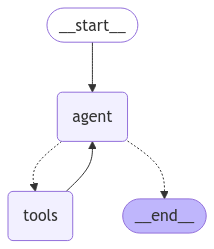

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)

text2sql_agent = create_react_agent(model=chatgpt,
                                    tools=sql_tools,
                                    state_modifier=SYS_PROMPT)
text2sql_agent

## Run and Test Text2SQL Agent

In [ ]:
from IPython.display import display, Markdown

for s in text2sql_agent.stream(
    {"messages": [HumanMessage(content="What is the total number of customers?")]}
):
    display(Markdown(str(s)))
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZgkleNoZbM1OnIVmJluv9GNb', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 649, 'total_tokens': 662, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-04580bbd-b52c-4b9c-bf13-9adedaed0f4d-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_ZgkleNoZbM1OnIVmJluv9GNb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 649, 'output_tokens': 13, 'total_tokens': 662, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


{'tools': {'messages': [ToolMessage(content='Branch, Comic, Customer, Employee, Inventory, Publisher, Sale, SaleTransactions', name='sql_db_list_tables', id='39d172cf-e3f8-4af5-b6fc-609bb106d106', tool_call_id='call_ZgkleNoZbM1OnIVmJluv9GNb')]}}

----


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AQZiRTjjePHyW2pWd9ToJhug', 'function': {'arguments': '{"table_names":"Customer"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 687, 'total_tokens': 704, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a97ede6d-cb2e-4023-ba81-3cd337bda9e6-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Customer'}, 'id': 'call_AQZiRTjjePHyW2pWd9ToJhug', 'type': 'tool_call'}], usage_metadata={'input_tokens': 687, 'output_tokens': 17, 'total_tokens': 704, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


{'tools': {'messages': [ToolMessage(content='\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(50) NOT NULL, \n\t"LastName" NVARCHAR(50) NOT NULL, \n\t"Email" NVARCHAR(100), \n\t"Phone" NVARCHAR(20), \n\t"Address" NVARCHAR(100), \n\t"City" NVARCHAR(50), \n\t"State" NVARCHAR(50), \n\t"Country" NVARCHAR(50) NOT NULL, \n\t"PostalCode" NVARCHAR(10), \n\tPRIMARY KEY ("CustomerId")\n)\n\n/*\n3 rows from Customer table:\nCustomerId\tFirstName\tLastName\tEmail\tPhone\tAddress\tCity\tState\tCountry\tPostalCode\n1\tRobert\tTaylor\trobert.taylor@example.com\t555-1111\t123 Main St\tNew York\tNY\tUSA\t10001\n2\tEmily\tDavis\temily.davis@example.com\t555-2222\t456 Oak St\tLos Angeles\tCA\tUSA\t90001\n3\tSarah\tConnor\tsarah.connor@example.com\t555-3333\t789 Pine St\tChicago\tIL\tUSA\t60601\n*/', name='sql_db_schema', id='a9712c6d-97ce-4eba-9408-57c4bb6ec757', tool_call_id='call_AQZiRTjjePHyW2pWd9ToJhug')]}}

----


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fYkJFMhE1N1uDH5OaHxwg6cb', 'function': {'arguments': '{"query":"SELECT COUNT(CustomerId) AS TotalCustomers FROM Customer;"}', 'name': 'sql_db_query'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 960, 'total_tokens': 986, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9735e2e-8d1a-45d9-8e3d-15021a83fb8d-0', tool_calls=[{'name': 'sql_db_query', 'args': {'query': 'SELECT COUNT(CustomerId) AS TotalCustomers FROM Customer;'}, 'id': 'call_fYkJFMhE1N1uDH5OaHxwg6cb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 960, 'output_tokens': 26, 'total_tokens': 986, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


{'tools': {'messages': [ToolMessage(content='[(20,)]', name='sql_db_query', id='f28fad5c-26c9-450d-b25d-fbde9b875ee5', tool_call_id='call_fYkJFMhE1N1uDH5OaHxwg6cb')]}}

----


{'agent': {'messages': [AIMessage(content='The total number of customers is 20.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 998, 'total_tokens': 1009, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'stop', 'logprobs': None}, id='run-0eec1e35-af4f-4a25-ac25-5d1dd5aead65-0', usage_metadata={'input_tokens': 998, 'output_tokens': 11, 'total_tokens': 1009, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

----


In [ ]:
for event in text2sql_agent.stream(
    {"messages": [HumanMessage(content="What are the Top 10 most popular comics?")]},
    stream_mode='values' #returns full agent state with all messages including updates
):
    event["messages"][-1].pretty_print()

print('\n\nFinal Response:\n')
display(Markdown(event["messages"][-1].content))

================================ Human Message =================================

What are the Top 10 most popular comics?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_T43bb5rdAsh0v2H6PKPvTNvm)
 Call ID: call_T43bb5rdAsh0v2H6PKPvTNvm
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Branch, Comic, Customer, Employee, Inventory, Publisher, Sale, SaleTransactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_kJvSozHXSkdgjfCSFX1LV2td)
 Call ID: call_kJvSozHXSkdgjfCSFX1LV2td
  Args:
    table_names: Comic, Sale
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Comic" (
	"ComicId" INTEGER NOT NULL, 
	"Title" NVARCHAR(100) NOT NULL, 
	"PublisherId" INTEGER NOT NULL, 
	"Genre" NVARCHAR(50), 
	"Price" NUMERIC(10, 2) NOT NU

Here are the Top 10 most popular comics based on sales:

1. Wolverine: Old Man Logan - 3 copies sold
2. V for Vendetta - 2 copies sold
3. Usagi Yojimbo Volume 1 - 2 copies sold
4. Transformers: All Hail Megatron - 2 copies sold
5. The Killing Joke - 2 copies sold
6. The Boys Volume 1 - 2 copies sold
7. Superman: Red Son - 2 copies sold
8. Punisher: Welcome Back, Frank - 2 copies sold
9. Preacher Volume 1 - 2 copies sold
10. Ms. Marvel Volume 1 - 2 copies sold

In [ ]:
def call_text2sql_agent(query, verbose=False):

    for event in text2sql_agent.stream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode='values' #returns full agent state with all messages including updates
    ):
        if verbose:
            event["messages"][-1].pretty_print()

    print('\n\nFinal Response:\n')
    display(Markdown(event["messages"][-1].content))


In [ ]:
call_text2sql_agent(query="What are the Top 10 most popular comics?",
                    verbose=True)

================================ Human Message =================================

What are the Top 10 most popular comics?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_9Ph48wbOs47MnUkJlMjjp4rc)
 Call ID: call_9Ph48wbOs47MnUkJlMjjp4rc
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Branch, Comic, Customer, Employee, Inventory, Publisher, Sale, SaleTransactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_9uEgGK8IqBVwEFplqhKtmDYb)
 Call ID: call_9uEgGK8IqBVwEFplqhKtmDYb
  Args:
    table_names: Comic, Sale
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Comic" (
	"ComicId" INTEGER NOT NULL, 
	"Title" NVARCHAR(100) NOT NULL, 
	"PublisherId" INTEGER NOT NULL, 
	"Genre" NVARCHAR(50), 
	"Price" NUMERIC(10, 2) NOT NU

Here are the Top 10 most popular comics based on sales:

1. Wolverine: Old Man Logan - 3 copies sold
2. Superman: Red Son - 2 copies sold
3. Ms. Marvel Volume 1 - 2 copies sold
4. Iron Man: Extremis - 2 copies sold
5. Locke & Key Volume 1 - 2 copies sold
6. V for Vendetta - 2 copies sold
7. The Boys Volume 1 - 2 copies sold
8. Lumberjanes Volume 1 - 2 copies sold
9. Punisher: Welcome Back, Frank - 2 copies sold
10. Invincible Volume 1 - 2 copies sold

In [ ]:
call_text2sql_agent(query="What are the top 5 customers with most comics purchased?",
                    verbose=False)



Final Response:



The top 5 customers with the most comics purchased are:

1. Tony Stark - 8 comics
2. Sarah Connor - 7 comics
3. Natasha Romanoff - 6 comics
4. Clark Kent - 6 comics
5. Diana Prince - 6 comics

In [ ]:
call_text2sql_agent(query="Which are the top 5 customers with most money spent",
                    verbose=False)



Final Response:



The top 5 customers with the most money spent are:

1. Tony Stark - \$164.94
2. Bruce Wayne - \$139.94
3. Sarah Connor - \$124.96
4. Clark Kent - \$114.96
5. Natasha Romanoff - \$111.96

In [ ]:
call_text2sql_agent(query="Which are the top 3 salesman with highest revenue",
                    verbose=False)



Final Response:



The top 3 salesmen with the highest revenue are:

1. John Doe with a total revenue of \$255.89
2. Alice Brown with a total revenue of \$234.94
3. Jane Smith with a total revenue of \$234.88